In [133]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV

pd.set_option('display.max_columns', None)

In [134]:
file_path = "/home/dasun/Projects/Research/ICUG/NoteBooks/data/Data.xlsx"
sheet_name = "Sheet3"

df_raw = pd.read_excel(file_path, sheet_name=sheet_name)

In [135]:
data_new = df_raw.copy()
columns_to_drop = ['Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21','Unnamed: 22', 'Name ', 'Birth place', 'Blood glucose']

data_new.drop(columns=columns_to_drop, inplace=True)

In [136]:
data_new.head()

,Gender,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Family history diabetics,Physical activity,Health Problem,Alcoholic,Blood Group,Food Item,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Male,23.0,93.5,171.5,31.79,99.1,107.0,0.93,No,Light ( Only Day-to-Day activities),No,Never,A+,Glucose Solution,2699.0,16.7,0,0,83.3,0,0
2,Male,23.0,93.5,171.5,31.79,99.1,107.0,0.93,No,Light ( Only Day-to-Day activities),No,Never,A+,Rice-Super kernal,1425.0,81.7 ± 0.7a,3.7 ± 0.6,1.1 ± 0.2,12.8 ± 0.3,0.7 ± 0.01,5.4 ± 0.2c
3,Female,23.0,47.7,156.8,19.40,69.7,87.0,0.80,No,Light ( Only Day-to-Day activities),No,Never,A+,Glucose Solution,2940.0,16.7,0,0,83.3,0,0
4,Female,23.0,47.7,156.8,19.40,69.7,87.0,0.80,No,Light ( Only Day-to-Day activities),No,Never,A+,Rice-Red Fragrant,7208.0,79.3 ± 0.1bc,4.9 ± 0.2,1.8 ± 0.2,12.9 ± 0.3,1.1 ± 0.01,5.0 ± 0.2c


In [137]:
df_cleaned = data_new.copy()

In [138]:
df_cleaned = df_cleaned.dropna(subset=['IAUC'])

In [139]:
def extract_numerical_value(text):
    if isinstance(text, (int, float)):
        return float(text)
    if isinstance(text, str):
        try:
            return float(text)
        except ValueError:
            match = re.match(r'(\d+\.?\d*)', text)
            if match:
                return float(match.group(1))
    return np.nan

columns_to_convert = ['Carb(g/100g)', 'Protien(g)', 'Fat(g)', 'Moisture(%)', 'Ash Content', 'Dietary Fiber']
for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].apply(extract_numerical_value)
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')


In [140]:
numerical_cols = ['Age', 'Weight(kg)', 'Height(cm)', 'Waist circumference', 'Hip circumference']
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

df_cleaned['BMI(kg/m2)'] = df_cleaned['Weight(kg)'] / ((df_cleaned['Height(cm)'] / 100) ** 2)
df_cleaned['WC/HC'] = df_cleaned['Waist circumference'] / df_cleaned['Hip circumference']

categorical_cols_na = ['Health Problem', 'Blood Group', 'Gender']
for col in categorical_cols_na:
    df_cleaned[col] = df_cleaned[col].fillna('Not Applicable')

df_cleaned['Family history diabetics'] = df_cleaned['Family history diabetics'].fillna('No')
df_cleaned['Physical activity'] = df_cleaned['Physical activity'].fillna('Light ( Only Day-to-Day activities)')
df_cleaned['Alcoholic'] = df_cleaned['Alcoholic'].fillna('Never')

columns_to_fill_zero = ['Moisture(%)', 'Ash Content', 'Dietary Fiber']
df_cleaned[columns_to_fill_zero] = df_cleaned[columns_to_fill_zero].fillna(0)

In [141]:
df_cleaned

,Gender,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Family history diabetics,Physical activity,Health Problem,Alcoholic,Blood Group,Food Item,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber
1,Male,23.0,93.5,171.5,31.789475,99.1,107.00,0.926168,No,Light ( Only Day-to-Day activities),No,Never,A+,Glucose Solution,2699.000000,16.70,0.00,0.00,83.3,0.00,0.00
2,Male,23.0,93.5,171.5,31.789475,99.1,107.00,0.926168,No,Light ( Only Day-to-Day activities),No,Never,A+,Rice-Super kernal,1425.000000,81.70,3.70,1.10,12.8,0.70,5.40
3,Female,23.0,47.7,156.8,19.401096,69.7,87.00,0.801149,No,Light ( Only Day-to-Day activities),No,Never,A+,Glucose Solution,2940.000000,16.70,0.00,0.00,83.3,0.00,0.00
4,Female,23.0,47.7,156.8,19.401096,69.7,87.00,0.801149,No,Light ( Only Day-to-Day activities),No,Never,A+,Rice-Red Fragrant,7208.000000,79.30,4.90,1.80,12.9,1.10,5.00
114,Female,24.0,45.0,155.0,18.730489,76.2,95.00,0.802105,No,Light ( Only Day-to-Day activities),Gastritis,Never (I don't drink alcohol),O+,Glucose Solution,3270.000000,16.70,0.00,0.00,83.3,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,No,Moderate (Home workouts),No,Moderate (Once/twice a week/month/year),B+,Glucose Solution,2779.928571,16.70,0.00,0.00,83.3,0.00,0.00
224,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,No,Moderate (Home workouts),No,Moderate (Once/twice a week/month/year),B+,Red Fragrance String Hoppers,1209.745989,69.40,10.35,2.16,0.0,1.10,0.45
225,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,No,Moderate (Home workouts),No,Moderate (Once/twice a week/month/year),B+,White Basmati String Hoppers,1597.122995,78.07,7.73,0.90,0.0,0.64,0.52
226,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,No,Moderate (Home workouts),No,Moderate (Once/twice a week/month/year),B+,Sticky Basmati String Hoppers,1680.000000,80.21,3.41,0.23,0.0,0.65,0.15


In [142]:
df_cleaned.isnull().sum()

Gender                      0
Age                         0
Weight(kg)                  0
Height(cm)                  0
BMI(kg/m2)                  0
Waist circumference         0
Hip circumference           0
WC/HC                       0
Family history diabetics    0
Physical activity           0
Health Problem              0
Alcoholic                   0
Blood Group                 0
Food Item                   0
IAUC                        0
Carb(g/100g)                0
Protien(g)                  0
Fat(g)                      0
Moisture(%)                 0
Ash Content                 0
Dietary Fiber               0
dtype: int64

In [143]:
df_cleaned.to_excel('out/df_cleaned.xlsx', index=False)

In [144]:
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
display(categorical_cols)

['Gender',
 'Family history diabetics',
 'Physical activity',
 'Health Problem',
 'Alcoholic',
 'Blood Group',
 'Food Item']

In [145]:
categorical_cols_onehot = [col for col in categorical_cols if col not in ['Food Item', 'Physical activity','Gender','Blood Group']]

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols_onehot, drop_first=True)

In [146]:
for col in ['Food Item', 'Physical activity','Gender','Blood Group']:
    target_mean_encoding = df_cleaned.groupby(col)['IAUC'].mean()
    df_encoded[col + '_TargetEncoded'] = df_cleaned[col].map(target_mean_encoding)

In [147]:
df_encoded

,Gender,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Physical activity,Blood Group,Food Item,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber,Family history diabetics_No,Family history diabetics_Yes-Father,Health Problem_No,Health Problem_Not Applicable,Alcoholic_Never,Alcoholic_Never ( I don't drink alcohol),Alcoholic_Never (I don't drink alcohol),Food Item_TargetEncoded,Physical activity_TargetEncoded,Gender_TargetEncoded,Blood Group_TargetEncoded
1,Male,23.0,93.5,171.5,31.789475,99.1,107.00,0.926168,Light ( Only Day-to-Day activities),A+,Glucose Solution,2699.000000,16.70,0.00,0.00,83.3,0.00,0.00,True,False,True,False,True,False,False,3518.577984,2588.359597,2092.305414,2762.878627
2,Male,23.0,93.5,171.5,31.789475,99.1,107.00,0.926168,Light ( Only Day-to-Day activities),A+,Rice-Super kernal,1425.000000,81.70,3.70,1.10,12.8,0.70,5.40,True,False,True,False,True,False,False,1425.000000,2588.359597,2092.305414,2762.878627
3,Female,23.0,47.7,156.8,19.401096,69.7,87.00,0.801149,Light ( Only Day-to-Day activities),A+,Glucose Solution,2940.000000,16.70,0.00,0.00,83.3,0.00,0.00,True,False,True,False,True,False,False,3518.577984,2588.359597,2623.834284,2762.878627
4,Female,23.0,47.7,156.8,19.401096,69.7,87.00,0.801149,Light ( Only Day-to-Day activities),A+,Rice-Red Fragrant,7208.000000,79.30,4.90,1.80,12.9,1.10,5.00,True,False,True,False,True,False,False,7208.000000,2588.359597,2623.834284,2762.878627
114,Female,24.0,45.0,155.0,18.730489,76.2,95.00,0.802105,Light ( Only Day-to-Day activities),O+,Glucose Solution,3270.000000,16.70,0.00,0.00,83.3,0.00,0.00,True,False,False,False,False,False,True,3518.577984,2588.359597,2623.834284,2419.793601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,Moderate (Home workouts),B+,Glucose Solution,2779.928571,16.70,0.00,0.00,83.3,0.00,0.00,True,False,True,False,False,False,False,3518.577984,1908.859821,2092.305414,2235.838492
224,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,Moderate (Home workouts),B+,Red Fragrance String Hoppers,1209.745989,69.40,10.35,2.16,0.0,1.10,0.45,True,False,True,False,False,False,False,1777.163034,1908.859821,2092.305414,2235.838492
225,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,Moderate (Home workouts),B+,White Basmati String Hoppers,1597.122995,78.07,7.73,0.90,0.0,0.64,0.52,True,False,True,False,False,False,False,1932.359664,1908.859821,2092.305414,2235.838492
226,Male,25.0,53.0,176.0,17.110021,76.2,83.82,0.909091,Moderate (Home workouts),B+,Sticky Basmati String Hoppers,1680.000000,80.21,3.41,0.23,0.0,0.65,0.15,True,False,True,False,False,False,False,2078.717516,1908.859821,2092.305414,2235.838492


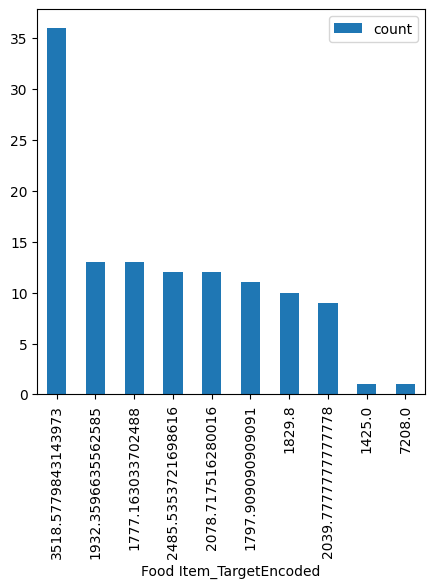

In [148]:
pd.DataFrame(df_encoded['Food Item_TargetEncoded'].value_counts()).plot(kind='bar', figsize=(5,5))
plt.show()

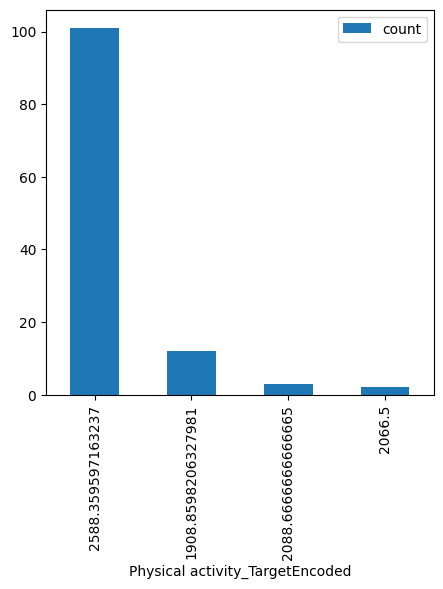

In [149]:
pd.DataFrame(df_encoded['Physical activity_TargetEncoded'].value_counts()).plot(kind='bar', figsize=(5,5))
plt.show()

In [150]:
df_encoded = df_encoded.drop(['Food Item', 'Physical activity','Gender','Blood Group'], axis=1)

In [151]:
df_encoded.to_excel('out/df_encoded.xlsx', index=False)

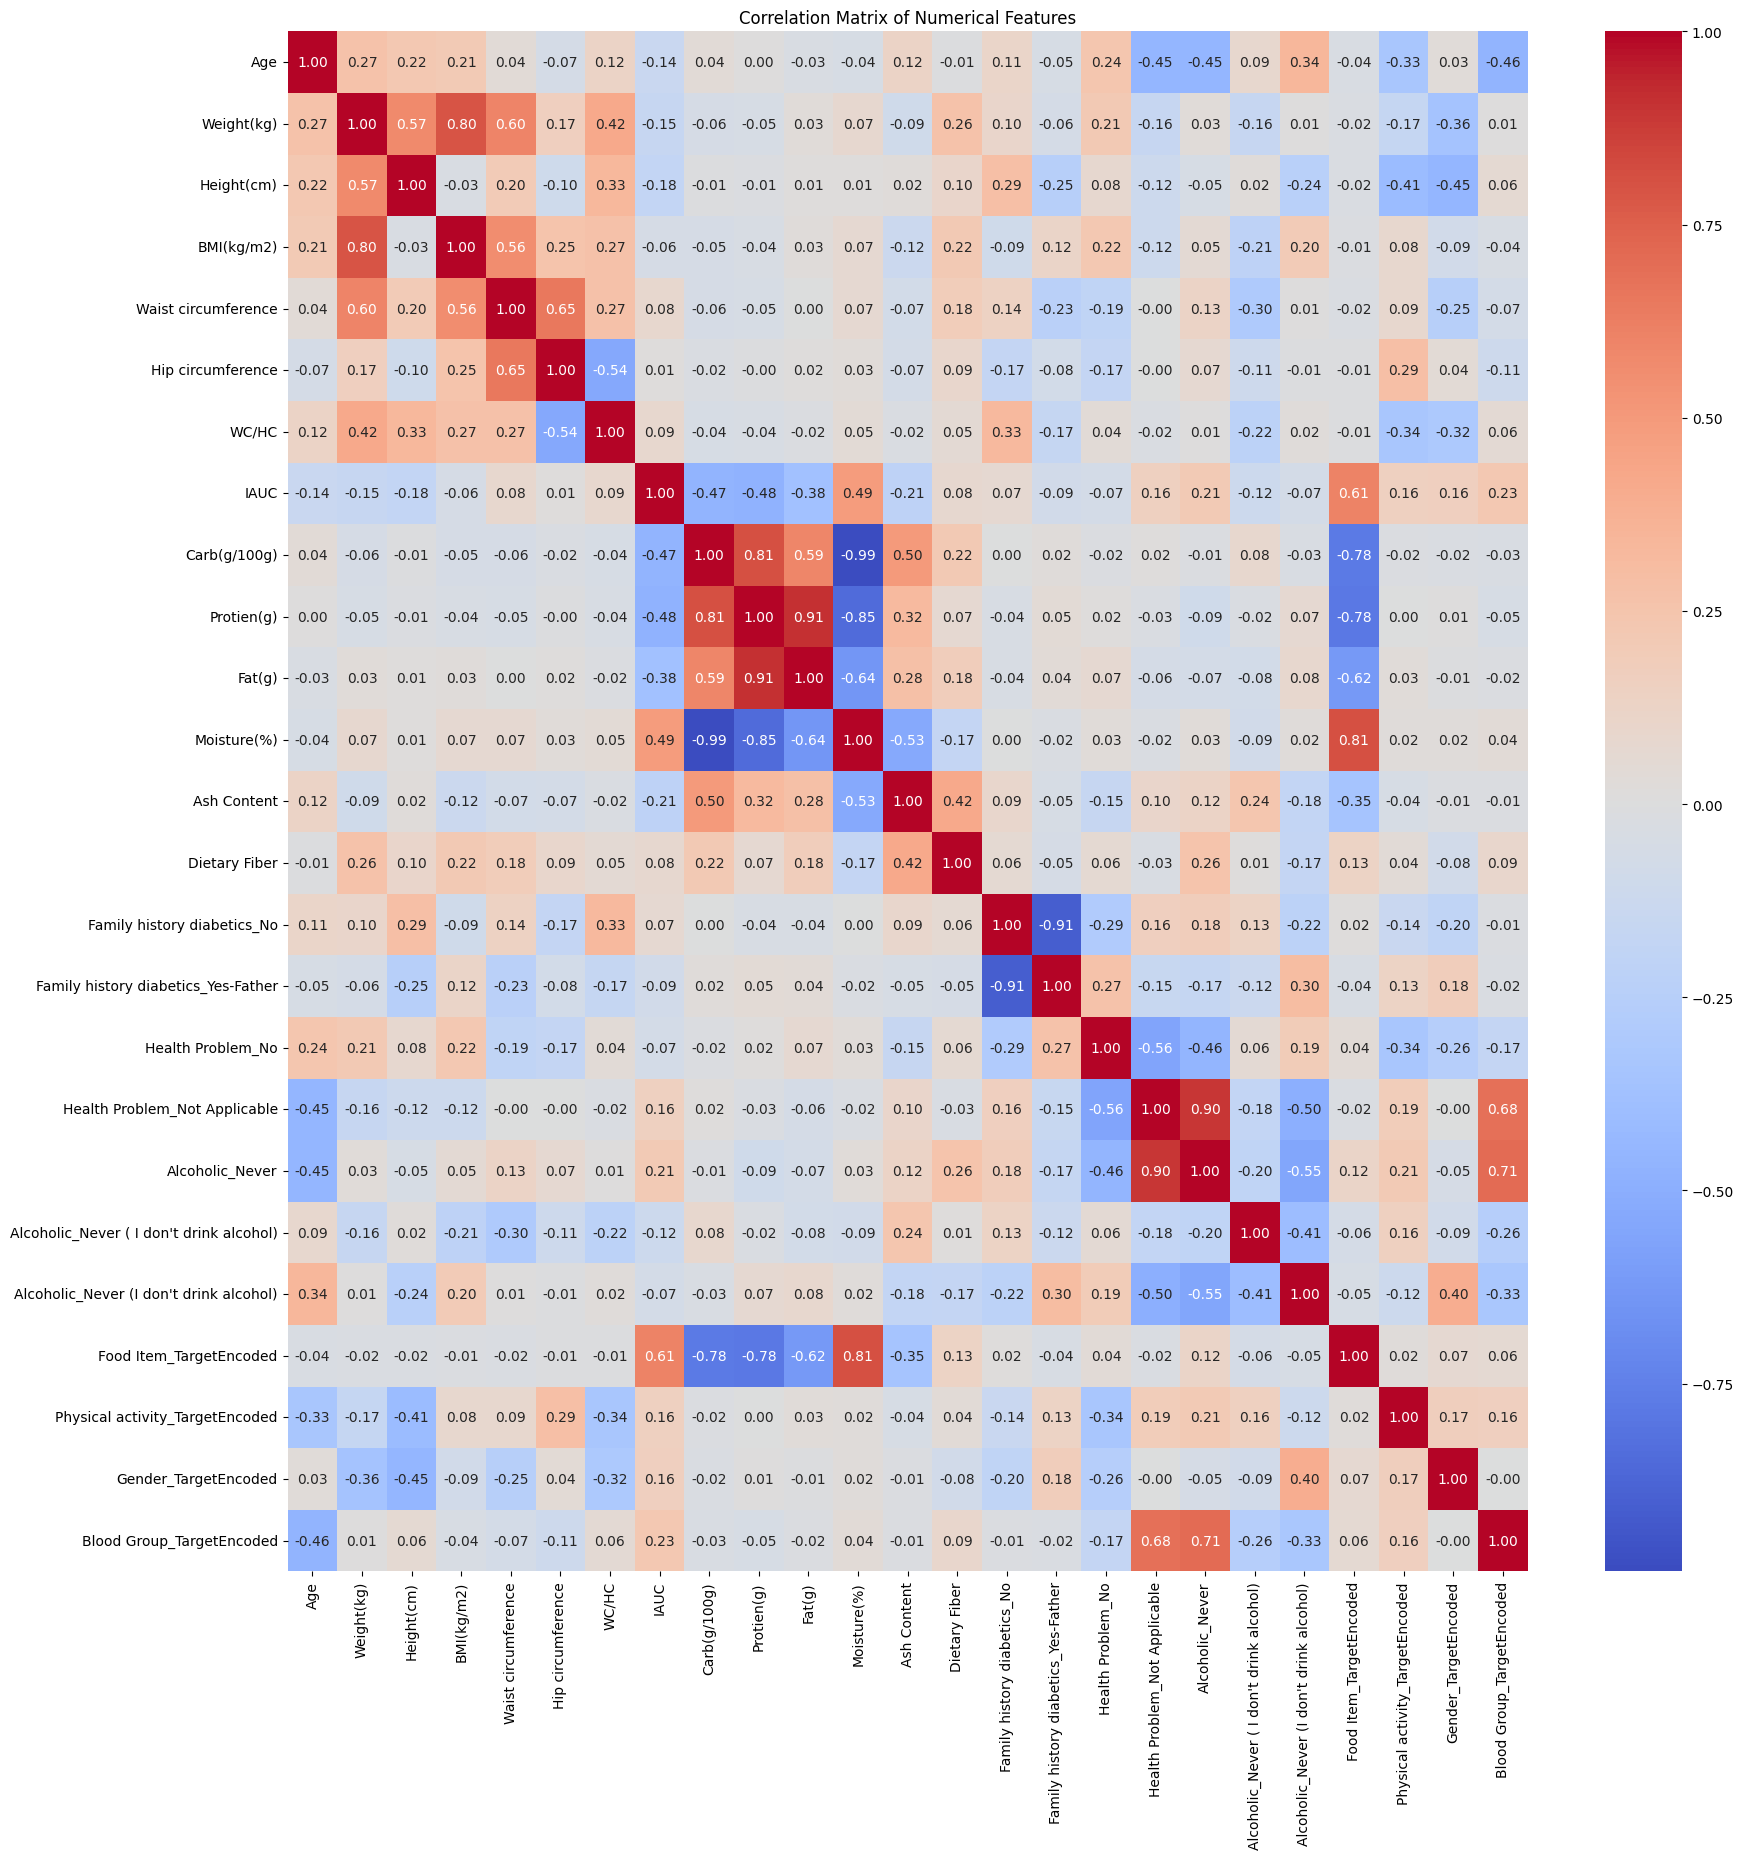

In [152]:
correlation_matrix_e = df_encoded.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_e, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.savefig("out/out.jpg")
plt.show()

In [153]:
y = df_encoded['IAUC']
X = df_encoded.drop('IAUC', axis=1)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)
sorted_lasso_coefficients = lasso_coefficients.abs().sort_values(ascending=False)

display(sorted_lasso_coefficients)

Food Item_TargetEncoded                     0.964349
Physical activity_TargetEncoded             0.487018
Blood Group_TargetEncoded                   0.449696
Gender_TargetEncoded                        0.208552
Age                                         0.000000
Weight(kg)                                  0.000000
Height(cm)                                  0.000000
BMI(kg/m2)                                  0.000000
Carb(g/100g)                                0.000000
WC/HC                                       0.000000
Hip circumference                           0.000000
Waist circumference                         0.000000
Protien(g)                                  0.000000
Fat(g)                                      0.000000
Moisture(%)                                 0.000000
Ash Content                                 0.000000
Health Problem_No                           0.000000
Family history diabetics_Yes-Father         0.000000
Family history diabetics_No                 0.

In [156]:
selector_e = SelectKBest(score_func=f_regression, k='all')
selector_e.fit(X, y)

feature_scores_e = pd.Series(selector_e.scores_, index=X.columns)
sorted_feature_scores_e = feature_scores_e.sort_values(ascending=False)

display(sorted_feature_scores_e)

Food Item_TargetEncoded                     67.339784
Moisture(%)                                 36.667813
Protien(g)                                  33.837865
Carb(g/100g)                                33.073373
Fat(g)                                      19.055226
Blood Group_TargetEncoded                    6.352056
Ash Content                                  5.506748
Alcoholic_Never                              5.283240
Height(cm)                                   3.920458
Gender_TargetEncoded                         3.082779
Physical activity_TargetEncoded              2.994295
Health Problem_Not Applicable                2.873863
Weight(kg)                                   2.829573
Age                                          2.416109
Alcoholic_Never ( I don't drink alcohol)     1.708726
Family history diabetics_Yes-Father          0.860467
WC/HC                                        0.848391
Waist circumference                          0.794234
Dietary Fiber               

In [157]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [158]:
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest Regressor - R-squared: {r2_rf:.2f}")

Random Forest Regressor - Mean Squared Error: 1737921.81
Random Forest Regressor - R-squared: 0.22


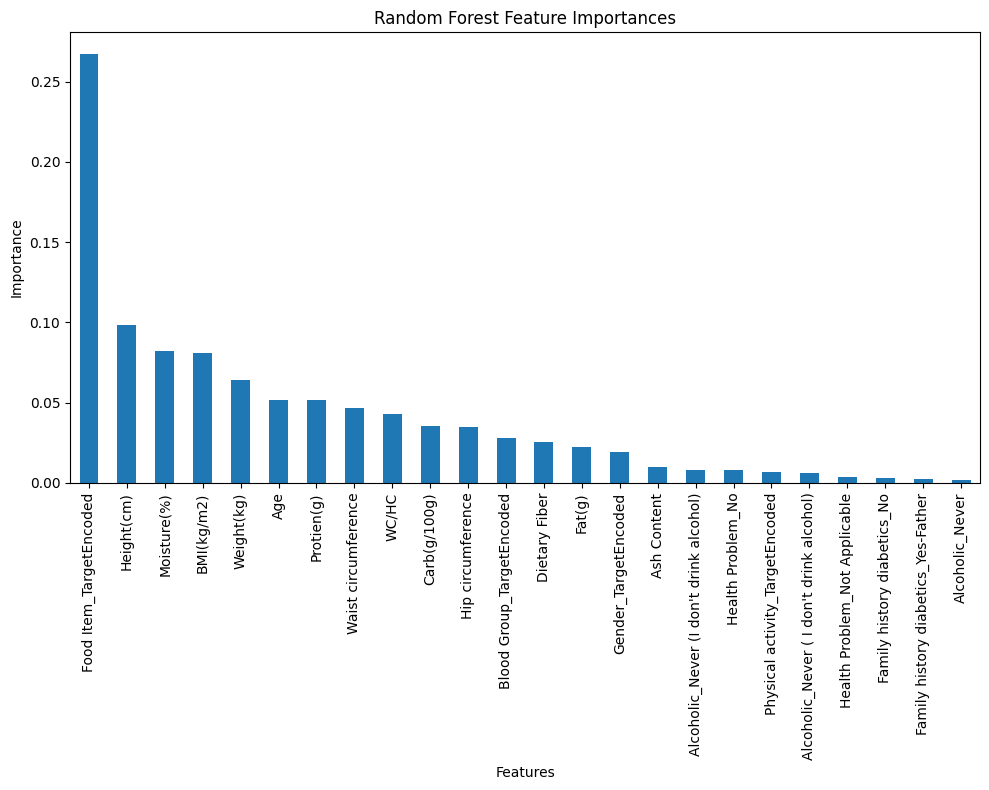

In [159]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

sorted_feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sorted_feature_importances.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("out/feature.jpg")
plt.show()

In [160]:
df_encoded_1 = df_encoded.drop(['Weight(kg)', 'Height(cm)','WC/HC'], axis=1)

In [161]:
y = df_encoded_1['IAUC']
X = df_encoded_1.drop('IAUC', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [163]:
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest Regressor - R-squared: {r2_rf:.2f}")

Random Forest Regressor - Mean Squared Error: 1847556.30
Random Forest Regressor - R-squared: 0.17


In [164]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best R-squared from GridSearchCV: {best_score:.2f}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best R-squared from GridSearchCV: 0.11
